In [1]:
import calendar
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
from shapely.geometry import Point

palette = sns.color_palette("colorblind", 20)


def to_geo(df, x_field='longitude', y_field='latitude'):
    geometry = [Point(xy) for xy in zip(df[x_field], df[y_field])]
    return gpd.GeoDataFrame(df, geometry=geometry)


spark = (
    SparkSession.builder
        .master("local")
        .appName("TFL Notebook")
        .config('spark.executor.memory', '8G')
        .config('spark.driver.memory', '16G')
        .config('spark.driver.maxResultSize', '10G')
        .config("spark.sql.crossJoin.enabled", "true")
        .getOrCreate()
)

trips = spark.read.parquet("../data/parquet_trip")
trips.createOrReplaceTempView("trips")

def month_label(year, month):
    return "{0} {1}".format(calendar.month_name[int(month)], year)
month_label_udf = udf(month_label, StringType())

schema = StructType([
    StructField("year",              IntegerType(), False),
    StructField("month",             IntegerType(), False),
    StructField("maximum_temp",      DoubleType(),  False),
    StructField("minimum_temp",      DoubleType(),  False),
    StructField("days_of_air_frost", DoubleType(),  False),
    StructField("total_rainfall",    DoubleType(),  False),
    StructField("total_sunshine",    DoubleType(),  False)
])

df = spark.read.csv("../data/weather/heathrow.csv", header='true', schema=schema)
df = df.filter((col('year') > 2014))
df = df.orderBy("year", "month")
df = df.withColumn("month_label", month_label_udf("year", "month"))
df.createOrReplaceTempView("weather")

weather = df.toPandas()

weather.head(6)


,year,month,maximum_temp,minimum_temp,days_of_air_frost,total_rainfall,total_sunshine,month_label
0,2015,1,8.8,1.6,10.0,63.4,62.0,January 2015
1,2015,2,8.0,1.8,8.0,38.6,63.9,February 2015
2,2015,3,11.6,4.1,1.0,24.0,140.7,March 2015
3,2015,4,16.3,6.0,0.0,16.2,212.1,April 2015
4,2015,5,17.6,8.8,0.0,41.6,189.0,May 2015
5,2015,6,22.2,11.4,0.0,12.2,197.0,June 2015


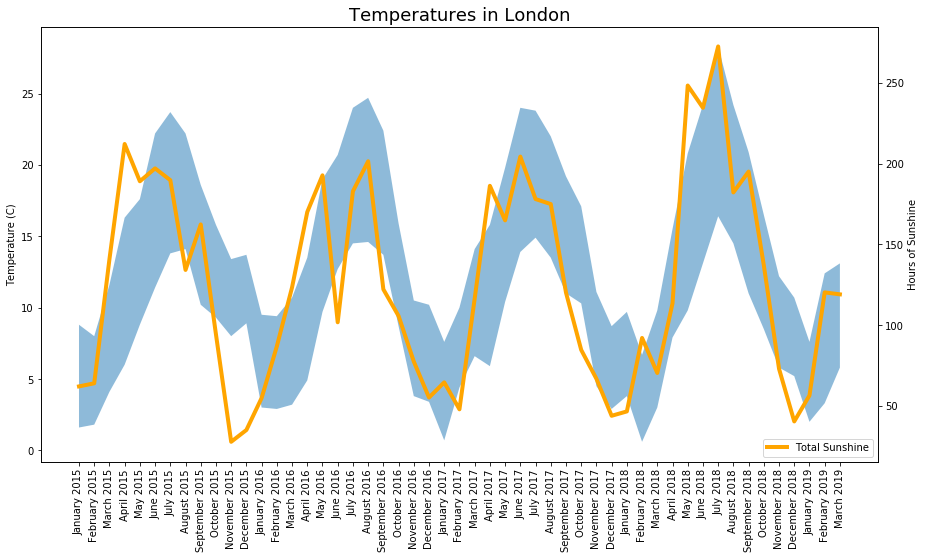

In [18]:
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.fill_between(weather['month_label'], weather['maximum_temp'], weather['minimum_temp'], label="Temperature: max-min", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(weather['month_label'], weather['total_sunshine'], linewidth=4.0, label="Total Sunshine", color="orange")

plt.title("Weather in London 2015-2018", fontsize=18)
ax1.set_ylabel('Temperature (C)')
ax1.tick_params(axis='x', rotation=90)
ax2.set_ylabel('Hours of Sunshine')
plt.legend(loc='lower right')
plt.show()